# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя


Целевой признак
Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import time


from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
 


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


import warnings #чтоб на ошибки не ругался
warnings.filterwarnings("ignore")

In [2]:
try:
    df= pd.read_csv('/datasets/autos.csv')
except:
    df=pd.read_csv('/Users/aleksandrivanov/Downloads/autos.csv')
pd.set_option('display.max_columns', None)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
#сделаем все буквы в нижний регистр, иначе будет угадывать где маленькая буква была, где большая
df.columns= df.columns.str.lower()

In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates(keep='first')
df = df.reset_index(drop=True)

In [8]:
df.duplicated().sum() #от явных дубликатов избавились

0

In [9]:
display(df)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354361,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [10]:
df.isnull().sum() #как все плохо с пропусками...

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
repaired             71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Посмотрим что у нас по колонкам, вдруг можно что-то и удалить...
1. datecrawled дата скачивания анкеты, у нас есть год регистрации
2. registrationmonth - у нас есть год
3. datecreated - дата создания анкеты, не очень информативный признак для цены, избавимся
4. numberofpictures - для цены не нужный признак, а вот для увеличения просмотров анкеты было бы интереснее
5. postalcode - вряд ли мы будем просить модель отправить письмо по этому индексу, удаляем
6. lastseen - тоже не помощник нам

Вывод: эти 6 колонок можно удалить из датасета, увы, проблему пропусков они не решают...

In [11]:
df = df.drop(['datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis = 1)

In [12]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [13]:
df.isnull().sum()

price                   0
vehicletype         37490
registrationyear        0
gearbox             19833
power                   0
model               19705
kilometer               0
fueltype            32895
brand                   0
repaired            71154
dtype: int64

In [14]:
print(df['gearbox'].value_counts())
print(df['gearbox'].unique())

manual    268249
auto       66283
Name: gearbox, dtype: int64
['manual' 'auto' nan]


у нас есть 3 варианта в машине коробки управления: механика, автоматом и что-то неизвестное, так как эти пропуски заменить на какое-то спец значение нельзя, то придется поставить заглушку, так как тут вопрос всё-таки не 1 тысячи строк, а 19 тысяч пропусков, это много для удаления.

In [15]:
print(df['vehicletype'].value_counts())
print(df['vehicletype'].unique())

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicletype, dtype: int64
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


в vehicletype пропуски заполним тоже в раздел other 

In [16]:
print(df['model'].value_counts())
print(df['model'].unique())

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 

тоже other... увы, для бизнеса такие пропуски всё-таки критичны, просто понимая, что модель в стоимости машины будет существенным моментом, такое количество пропусков в этом столбце это плохо...

In [17]:
print(df['fueltype'].value_counts())
print(df['fueltype'].unique())

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


32 тысячи машин криво заполнили на чём они ездят... пока отнесем к other, так как тут никак не придумать по другому

In [18]:
print(df['repaired'].value_counts())
print(df['repaired'].unique())

no     247158
yes     36053
Name: repaired, dtype: int64
[nan 'yes' 'no']


71 тысяча... пусть будет тоже other

In [19]:
for column in ['vehicletype', 'gearbox', 'model', 'fueltype', 'repaired']:
    df[column] = df[column].fillna('other')
df.isnull().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
repaired            0
dtype: int64

С пропусками разобрались.

Предварительные выводы по пропускам:

Датасет не маленький, есть большое количество различных данных, присутствовало несколько явных дубликатов, работу вести по неявным сложно, так как отличия даже в пару км у одной и той же машины может означать как и повтор, так и разные позиции. Следует поговорить с бизнесом и разработчиком, почему так много пропусков в разных столбцах. 

In [20]:
df.describe()

,price,registrationyear,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


<AxesSubplot:>

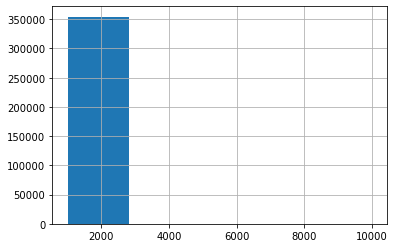

In [21]:
df['registrationyear'].hist(bins = 5)

<AxesSubplot:>

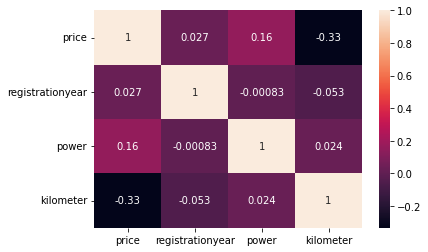

In [22]:
sns.heatmap(df.corr(), annot=True)

In [23]:
print( df[df['registrationyear'] > 2016]) # о_О машины из будущего, опасно...

        price vehicletype  registrationyear gearbox  power    model  \
22       2900       other              2018  manual     90   meriva   
26       5555       other              2017  manual    125       c4   
48       7750       other              2017  manual     80     golf   
51       2000       other              2017  manual     90    punto   
57       2399       other              2018  manual     64    other   
...       ...         ...               ...     ...    ...      ...   
354108   3600       other              2017  manual     86  transit   
354136   1000       other              2017  manual    101       a4   
354199   2140       other              2018  manual     80   fiesta   
354249   1250       other              2018   other      0    corsa   
354285   5000       other              2017  manual    120    other   

        kilometer  fueltype       brand repaired  
22         150000    petrol        opel       no  
26         125000     other     citroen      

In [24]:
print( (df[df['registrationyear'] > 2016]).count())# 105 машин со странным годом годом регистрации, лучше избавлюсь я от них

price               14530
vehicletype         14530
registrationyear    14530
gearbox             14530
power               14530
model               14530
kilometer           14530
fueltype            14530
brand               14530
repaired            14530
dtype: int64


In [25]:
df = df.query("registrationyear < 2016")

<AxesSubplot:>

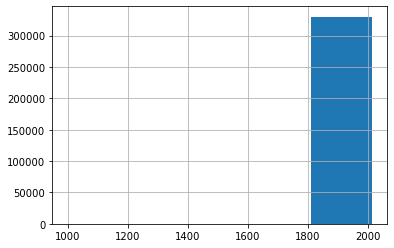

In [26]:
df['registrationyear'].hist(bins = 5)

In [27]:
df = df.query("registrationyear > 1900")

<AxesSubplot:>

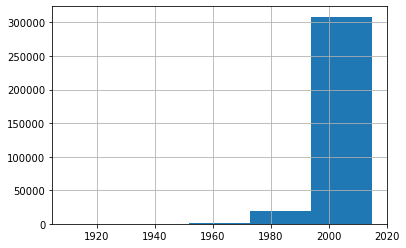

In [28]:
df['registrationyear'].hist(bins = 5)

In [29]:
df.describe()

,price,registrationyear,power,kilometer
count,330170.000000,330170.000000,330170.000000,330170.000000
mean,4540.142793,2002.089236,111.899603,127920.783233
std,4564.406192,6.802969,182.411127,37913.367297
min,0.000000,1910.000000,0.000000,5000.000000
25%,1149.000000,1999.000000,70.000000,125000.000000
50%,2850.000000,2002.000000,105.000000,150000.000000
75%,6500.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2015.000000,20000.000000,150000.000000


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330170 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             330170 non-null  int64 
 1   vehicletype       330170 non-null  object
 2   registrationyear  330170 non-null  int64 
 3   gearbox           330170 non-null  object
 4   power             330170 non-null  int64 
 5   model             330170 non-null  object
 6   kilometer         330170 non-null  int64 
 7   fueltype          330170 non-null  object
 8   brand             330170 non-null  object
 9   repaired          330170 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.7+ MB


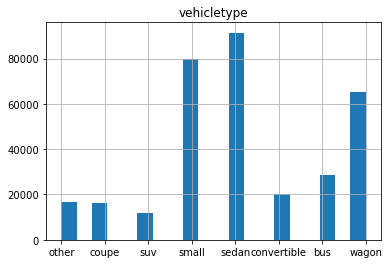

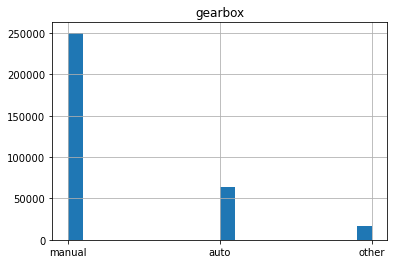

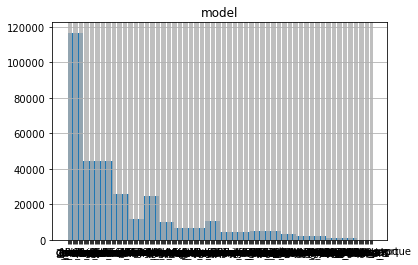

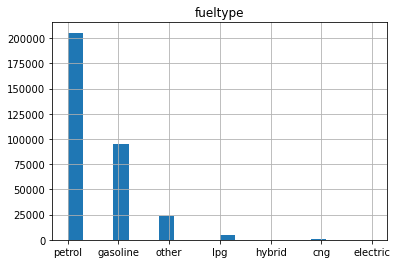

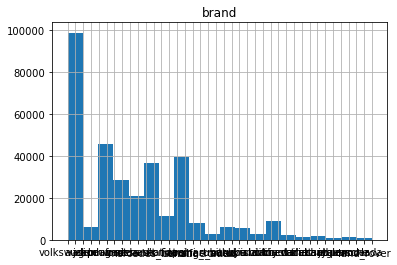

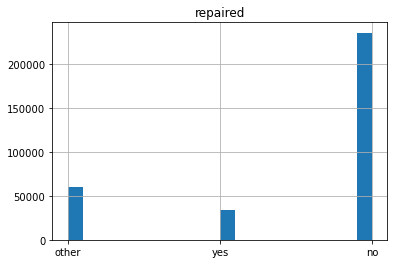

In [31]:
for i in ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']:
    df[i].hist(bins = 20)
    plt.title(i)
    plt.show()

Дисбаланс между данными есть, но он естественный\
Теперь посмотрим что там с прайсом 0... 

<AxesSubplot:xlabel='price'>

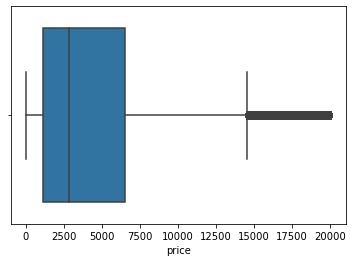

In [32]:
sns.boxplot(df['price'])

In [33]:
df.query('price == 0 ').head(15)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,other,1990,other,0,corsa,150000,petrol,opel,other
115,0,small,1999,other,0,other,5000,petrol,volkswagen,other
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
154,0,other,2006,other,0,other,5000,other,fiat,other
231,0,wagon,2001,manual,115,mondeo,150000,other,ford,other
334,0,other,2005,other,0,polo,150000,petrol,volkswagen,other
415,0,other,1985,other,0,3er,150000,other,bmw,other
471,0,other,1990,other,0,3er,5000,other,bmw,other
478,0,other,2000,manual,0,other,150000,other,audi,yes


In [34]:
df.query('price == 0 ').count()

price               9377
vehicletype         9377
registrationyear    9377
gearbox             9377
power               9377
model               9377
kilometer           9377
fueltype            9377
brand               9377
repaired            9377
dtype: int64

10.7 тысяч машин отдают бесплатно, есть как старые, так и новые. Почему это так - не понятно, вопросы к бизнесу..

всё-таки предлагаю убрать нулевые стоимости машин, а так же привести в порядок мощности, ибо по верхней границе какие-то машины убийцы...

In [35]:
df.describe()

,price,registrationyear,power,kilometer
count,330170.000000,330170.000000,330170.000000,330170.000000
mean,4540.142793,2002.089236,111.899603,127920.783233
std,4564.406192,6.802969,182.411127,37913.367297
min,0.000000,1910.000000,0.000000,5000.000000
25%,1149.000000,1999.000000,70.000000,125000.000000
50%,2850.000000,2002.000000,105.000000,150000.000000
75%,6500.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2015.000000,20000.000000,150000.000000


<AxesSubplot:xlabel='power'>

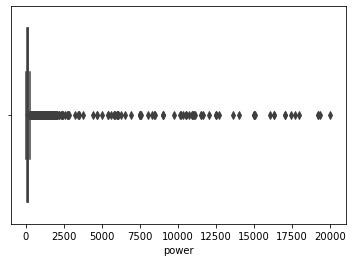

In [36]:
sns.boxplot(df['power'])

<AxesSubplot:>

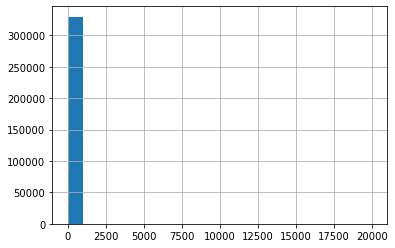

In [37]:
df['power'].hist(bins = 20)

In [38]:
df = df.query("power < 2500")

In [39]:
df = df.query("price > 5")

In [40]:
df.describe()

,price,registrationyear,power,kilometer
count,319611.000000,319611.000000,319611.000000,319611.000000
mean,4689.217674,2002.236725,110.570265,128087.331162
std,4562.918034,6.610562,71.253375,37453.784143
min,7.000000,1910.000000,0.000000,5000.000000
25%,1250.000000,1999.000000,73.000000,125000.000000
50%,2999.000000,2003.000000,105.000000,150000.000000
75%,6800.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2015.000000,2461.000000,150000.000000


общий вывод по разделу:\
Данные предоставлено небрежно, отсутствует много важной информации, присутствует как много пропусков, так и не всегда адекватные значения вбиты в требуемые поля. Необходимо обсудить с разработчиками и менеджерами эти моменты при заполнении, чтоб в будущем можно было доучить модель уже по более адекватным данным 

В целом между данными есть дисбаланс, но он естественный, а не из-за выборки

## Обучение моделей

Моя цель в рамках этого проекта разобраться с 3 основными способами градиентного бустинга: XGBoost, LightGBM и CatBoost. Сравнить их результаты и хоть немного понять как они работают. Так же пытаюсь разобраться с этими моделями при совместной работе с GridsearchCV

первая модель для эксперимента будет - catboost, так как он сам умеет "переваривать" категориальные переменные, т.е. ему не требуется предварительного OHE данных.

In [41]:
features = df.drop(['price'], axis=1)
target = df['price']

In [42]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [43]:
features_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
64966,wagon,2002,manual,101,passat,150000,gasoline,volkswagen,no
190868,bus,2003,manual,97,zafira,150000,cng,opel,no
31959,small,2009,manual,75,one,80000,petrol,mini,no
145753,small,1999,auto,90,a_klasse,150000,gasoline,mercedes_benz,no
7408,small,2005,manual,60,corsa,90000,petrol,opel,no


In [44]:
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

In [45]:
%%time
start_time = time.time()
catboost = CatBoostRegressor(loss_function='RMSE', verbose = False)
cat_m = catboost.fit(features_train, target_train, cat_features=cat_features, verbose = False)
cat_time = time.time() - start_time

CPU times: user 4min 8s, sys: 8.35 s, total: 4min 16s
Wall time: 44.8 s


In [46]:
print(cat_m.best_score_)

{'learn': {'RMSE': 1532.195044512251}}


In [47]:
feature_importances= cat_m.feature_importances_
feature_importances

array([ 7.45547316, 41.39512984,  1.000478  , 24.82566139,  4.30768887,
        6.30995747,  1.59909458, 10.3182302 ,  2.78828648])

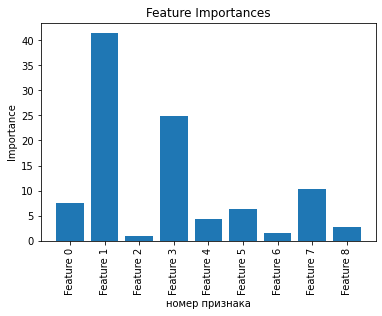

In [48]:
plt.bar(range(len(feature_importances)), feature_importances)


plt.title('Feature Importances')
plt.xlabel('номер признака')
plt.ylabel('Importance')


features = [f'Feature {i}' for i in range(len(feature_importances))]
plt.xticks(range(len(feature_importances)), features, rotation=90)


plt.show()

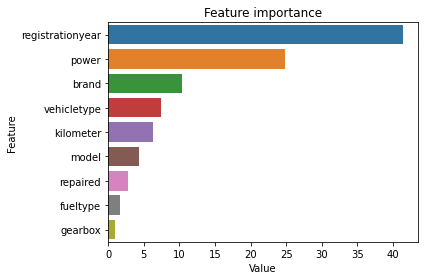

In [49]:
feature_importance = cat_m.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

In [50]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False)

In [51]:
%%time
start_time = time.time()

params_cat = {'depth':range(9,10), 'learning_rate':np.arange(0.1,0.6,0.2)}

catboost_grid = GridSearchCV(catboost, params_cat, cv=2, n_jobs = -1, scoring = rmse_scorer, verbose = False)
catboost_grid.fit(features_train, target_train, cat_features=cat_features)
cat_grid_time = time.time() - start_time

CPU times: user 6min 26s, sys: 20.2 s, total: 6min 46s
Wall time: 4min 3s


In [52]:
print(catboost_grid.best_params_)
print(catboost_grid.best_score_*-1)


{'depth': 9, 'learning_rate': 0.1}
1577.6619762241378


In [53]:
print(catboost_grid.cv_results_)

{'mean_fit_time': array([174.26898205, 174.11722302, 174.02418196]), 'std_fit_time': array([0.60043108, 0.03538609, 1.09821308]), 'mean_score_time': array([0.33317697, 0.64417183, 0.40618956]), 'std_score_time': array([0.02744305, 0.03652894, 0.01590645]), 'param_depth': masked_array(data=[9, 9, 9],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.1, 0.30000000000000004, 0.5000000000000001],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'depth': 9, 'learning_rate': 0.1}, {'depth': 9, 'learning_rate': 0.30000000000000004}, {'depth': 9, 'learning_rate': 0.5000000000000001}], 'split0_test_score': array([-1583.71322167, -1593.64824747, -1628.6736771 ]), 'split1_test_score': array([-1571.61073078, -1582.79200279, -1624.56820725]), 'mean_test_score': array([-1577.66197622, -1588.22012513, -1626.62094217]), 'std_test_score': array([6.05124544, 5.428122

На обучающей выборке у catboost получились следующие результаты:
{'depth': 9, 'learning_rate': 0.1}\
1577
CPU times: user 6min 57s, sys: 20.5 s, total: 7min 17s\
Wall time: 4 минуты

In [54]:
importances = catboost_grid.best_estimator_.feature_importances_

In [55]:
for i, feature in enumerate(features):
    print(f'{feature}: {importances[i]}')

Feature 0: 9.074432520375238
Feature 1: 33.47432543337264
Feature 2: 1.7683917266355473
Feature 3: 22.454847707753707
Feature 4: 5.734420257965039
Feature 5: 7.480889147043498
Feature 6: 2.550674670201187
Feature 7: 14.112987206013697
Feature 8: 3.34903133063915


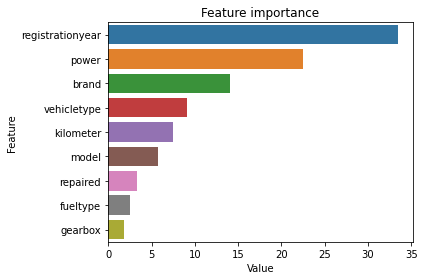

In [56]:
feature_importance = catboost_grid.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

XGBRegressor

In [57]:
encoder = OrdinalEncoder() 
features_train_oe = pd.DataFrame(encoder.fit_transform(features_train),
                            columns=features_train.columns)

In [58]:
features_train_oe

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,7.0,74.0,1.0,101.0,170.0,12.0,2.0,38.0,0.0
1,0.0,75.0,1.0,97.0,249.0,12.0,0.0,24.0,0.0
2,5.0,81.0,1.0,75.0,165.0,8.0,6.0,21.0,0.0
3,5.0,71.0,0.0,90.0,33.0,12.0,2.0,20.0,0.0
4,5.0,77.0,1.0,60.0,83.0,9.0,6.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...
255683,4.0,83.0,1.0,86.0,116.0,6.0,6.0,38.0,0.0
255684,5.0,71.0,1.0,110.0,120.0,12.0,2.0,30.0,2.0
255685,3.0,72.0,2.0,60.0,102.0,12.0,5.0,10.0,1.0
255686,7.0,58.0,1.0,113.0,166.0,12.0,6.0,39.0,0.0


In [59]:
model_xgb = XGBRegressor ()

In [60]:
%%time
start_time = time.time()

params_xgb = {
        'n_estimators': [10,20, 30],
        'max_depth': [3, 8],
        'eta': [0.5, 1]
        }
grid_xgb = GridSearchCV(XGBRegressor(), params_xgb, n_jobs=-1, scoring = rmse_scorer, verbose = 10, cv = 3)

grid_xgb.fit(features_train_oe, target_train)
xgb_grid_time = time.time() - start_time

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: user 15.2 s, sys: 2.37 s, total: 17.5 s
Wall time: 16 s


In [61]:
print(grid_xgb.best_score_*-1)

1653.2976350976853


In [62]:
print(grid_xgb.cv_results_)

{'mean_fit_time': array([0.73636492, 1.30603536, 1.82233071, 1.9302783 , 3.49494274,
       5.28042642, 0.69868437, 1.29434768, 1.84673564, 1.90350779,
       3.30644989, 4.56403685]), 'std_fit_time': array([0.00948653, 0.07673235, 0.03526426, 0.02331911, 0.04413497,
       0.04996595, 0.0085855 , 0.03270839, 0.01789887, 0.07619416,
       0.05333588, 0.01447036]), 'mean_score_time': array([0.03997342, 0.063574  , 0.05776238, 0.05544043, 0.08730133,
       0.13161429, 0.04092725, 0.04324007, 0.05010374, 0.05539759,
       0.07168627, 0.09001708]), 'std_score_time': array([0.00442294, 0.014437  , 0.00348069, 0.00316838, 0.01031088,
       0.01932783, 0.00204302, 0.00332942, 0.00180745, 0.00394322,
       0.00036552, 0.00186583]), 'param_eta': masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1, 1, 1],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object), 'param_

In [63]:
importances = grid_xgb.best_estimator_.feature_importances_

In [64]:
for i, feature in enumerate(features):
    print(f'{feature}: {importances[i]}')

Feature 0: 0.049233995378017426
Feature 1: 0.4748140871524811
Feature 2: 0.03276285529136658
Feature 3: 0.222534641623497
Feature 4: 0.027214206755161285
Feature 5: 0.041444871574640274
Feature 6: 0.02912505343556404
Feature 7: 0.059576354920864105
Feature 8: 0.06329391151666641


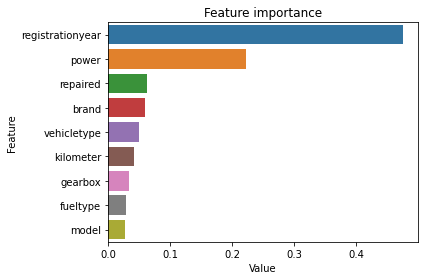

In [65]:
feature_importance = grid_xgb.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

In [66]:
def oneHotEncode(df):
    # инициализируем кодировщик
    ohe = OneHotEncoder()

    # получаем список незакодированных признаков
    non_encoded_columns = [col for col in df.columns if df[col].dtype == 'object']

    # кодируем незакодированные признаки
    encoded_columns = ohe.fit_transform(df[non_encoded_columns]).toarray()

    # сохраняем имена кодированных признаков
    encoded_columns_names = ohe.get_feature_names(non_encoded_columns)

    # сохраняем имена исходных незакодированных признаков
    non_encoded_columns_names = df[non_encoded_columns].columns.values

    # удаляем незакодированные признаки
    df.drop(non_encoded_columns, axis=1, inplace=True)

    # добавляем кодированные признаки
    for col, name in zip(encoded_columns.T, encoded_columns_names):
        df[name] = col

    return df


In [67]:
features_train_ohe = oneHotEncode(features_train)

In [68]:
#numeric = ['vehicletype','registrationyear','gearbox','power','model','kilometer','fueltype','brand','repaired']
numeric = ['registrationyear','power','kilometer']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
#features_test[numeric] = scaler.transform(features_test[numeric])

In [69]:
%%time
start_time = time.time()
reg = LinearRegression()
parameters = {} #гриду для линейной регрессии не нужны доп параметры, 
#там всё "зашито" внутри по умолчанию, либо настраивать их вручну.
grid_line = GridSearchCV(reg, param_grid = parameters, n_jobs = -1, scoring = rmse_scorer)
model_line = grid_line.fit(features_train_ohe,target_train) #обучаем
line_grid_time = time.time() - start_time

CPU times: user 7.65 s, sys: 1.68 s, total: 9.33 s
Wall time: 14.1 s


In [70]:
print(model_line.best_score_*-1)

1174368246310.3025


результат получился весьма странный...

попробуем теперь lightGBM

In [71]:
param_grid = {
    'num_leaves': [10, 20, 31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [10, 20, 50]
}

In [72]:
model_lgbm = LGBMRegressor()

In [73]:
%%time
start_time = time.time()
grid_lgb = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, cv=5, scoring = rmse_scorer)
grid_lgb.fit(features_train_oe, target_train)
lgbm_grid_time = time.time() - start_time

CPU times: user 7min 27s, sys: 1min 33s, total: 9min 1s
Wall time: 1min 45s


In [74]:
print(grid_lgb.best_score_*-1)

1743.55496189464


In [75]:
print(grid_lgb.cv_results_)

{'mean_fit_time': array([0.15903916, 0.20184565, 0.20514584, 0.26277251, 0.32957683,
       0.23751922, 0.31539383, 0.37183485, 0.40902643, 0.49316587,
       0.41132503, 0.68093209, 0.76210818, 0.86233258, 1.05951257,
       0.14223409, 0.16056747, 0.22355223, 0.26832871, 0.27979212,
       0.207234  , 0.27980404, 0.36918812, 0.40894885, 0.46157479,
       0.37509122, 0.60529604, 0.7921978 , 0.90032835, 1.10791168,
       0.1592257 , 0.19895539, 0.22110763, 0.24909191, 0.33178539,
       0.21982365, 0.28488173, 0.37925243, 0.41051936, 0.5407485 ,
       0.44601951, 0.55650959, 0.86111331, 0.81835923, 1.08460736]), 'std_fit_time': array([0.02113752, 0.02140784, 0.01458001, 0.01062018, 0.01541367,
       0.01626782, 0.03357185, 0.02647657, 0.03026219, 0.03345334,
       0.02703218, 0.16562311, 0.08909873, 0.03796243, 0.11773306,
       0.00563706, 0.01573461, 0.01845971, 0.01938281, 0.00874415,
       0.01370946, 0.0113854 , 0.06130173, 0.02776883, 0.04767994,
       0.03417357, 0.06658

In [76]:
importances = grid_lgb.best_estimator_.feature_importances_

In [77]:
for i, feature in enumerate(features):
    print(f'{feature}: {importances[i]}')

Feature 0: 284
Feature 1: 446
Feature 2: 61
Feature 3: 524
Feature 4: 273
Feature 5: 215
Feature 6: 68
Feature 7: 459
Feature 8: 120


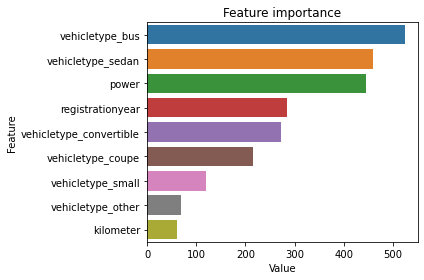

In [78]:
feature_importance = grid_lgb.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

## Анализ моделей

Все 3 варианта показали результат значительно лучше, чем было требование в 2500, но всё-таки для тестовой модели больше всего вызывает доверие грид + котбуст, поэтому испытаем финальную модель на нём

In [79]:
final_test = catboost_grid.predict(features_test)
print(rmse(target_test, final_test))

1562.0728155960333


сравним затраченное время моделями на обучение

In [81]:
print('линейна регресси', line_grid_time)
print ('Catboost без грида', cat_time )
print ('Catboost с гридом', cat_grid_time )
print ('XBB c гридом', xgb_grid_time )
print ('LGBM с гридом', lgbm_grid_time)

линейна регресси 14.118206977844238
Catboost без грида 44.77116012573242
Catboost с гридом 243.47290992736816
XBB c гридом 15.998924970626831
LGBM с гридом 105.5834538936615


Выводы:

очень грязные данные, требуется много проработать и с менеджером и с разработчиком, либо по рукам тому, что их так испортил =) /
В результате анализа данных были получены следующие выводы:

между некоторыми признаками есть корреляция, но она слабая/
часть столбцов были удалены, так как сильного эффекта для обучения они нам не давали, либо дублировали информацию/
Библиотека lightGBM с маком работает не очень корректно, совсем плохо.../

Библиотека catboost без грида с минимальным количеством гиперпараметров работает терпимо по скорости, инструменты с гридом за счёт кросс валидации считаются значительно дольше.

Требуемый порог в метрике 2500 прошли все модели

Для контрольного тестирования была выбрана модель гридсерч + кетбуст, результат 1562, что значительно лучше требуемого


